In [1]:
# Main file that is used for performing experiments.

import matplotlib.pyplot as plt
import numpy as np
from mlxtend.plotting import plot_decision_regions
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion
from sklearn import model_selection

from confusion_matrix import plot_confusion_matrix
from data_processing import get_data
from metric_labeling import metric_labeling, train_nnc
from polarity_feature import make_polarity_features
from util import Author

# Load preprocessed data.
data, sentences = get_data(Author.SCHWARTZ)

y = data.iloc[:, 1].values
possible_labels = np.unique(y)
# Split training data
data_train, data_test, labels_train, labels_test = train_test_split(sentences, y,
                                                                    test_size=0.20,
                                                                    random_state=42)

vectorizer_tf = TfidfVectorizer(max_features=12000)
# X_tf_train = vectorizer_tf.fit_transform(data_train)
# X_tf_test = vectorizer_tf.transform(data_test)

# This vocabulary can be extended with other words
my_vocabulary = ["?"]
vectorizer_voc = CountVectorizer(vocabulary=my_vocabulary,
                                 token_pattern=r"(?u)\b\w\w+\b|\?")
# X_voc_train = vectorizer_voc.fit_transform(data_train)
# X_voc_test = vectorizer_voc.transform(data_test)

X_combined_train = FeatureUnion([('TfidfVectorizer', vectorizer_tf), ('CountVectorizer', vectorizer_voc)])
X_combined_train = X_combined_train.fit_transform(data_train).todense()

X_combined_test = FeatureUnion([('TfidfVectorizer', vectorizer_tf), ('CountVectorizer', vectorizer_voc)])
X_combined_test = X_combined_test.transform(data_test).todense()

PSP_array_train, last_sentence_sentiment_array_train, first_sentence_sentiment_array_train = make_polarity_features(data_train)
PSP_array_test, last_sentence_sentiment_array_test, first_sentence_sentiment_array_test = make_polarity_features(data_test)

# # Append these features to the original feature matrix
# X_combined_train = np.hstack((X_combined_train, np.asmatrix(PSP_array_train)))
X_combined_train = np.hstack(
    (X_combined_train, np.asmatrix(last_sentence_sentiment_array_train)))
# #X_combined_train = np.hstack(
# #    (X_combined_train, np.asmatrix(first_sentence_sentiment_array_train)))

# X_combined_test = np.hstack((X_combined_test, np.asmatrix(PSP_array_test)))
X_combined_test = np.hstack(
    (X_combined_test, np.asmatrix(last_sentence_sentiment_array_test)))
# #X_combined_test = np.hstack(
# #    (X_combined_test, np.asmatrix(first_sentence_sentiment_array_test)))

y = data['class'].values
print("\nClass values: ")
print(str(y))

print("\nFeature array: ")
print(X_combined_train)



Starting to make sentiment features, this will take some time...
Finished making sentiment features.

Starting to make sentiment features, this will take some time...
Finished making sentiment features.

Class values: 
[0 0 0 ... 2 2 2]

Feature array: 
[[0.         0.         0.         ... 0.         0.         0.77023855]
 [0.         0.         0.         ... 0.         0.         0.98170133]
 [0.         0.         0.         ... 0.         0.         0.39076287]
 ...
 [0.         0.         0.         ... 0.         0.         0.58774326]
 [0.         0.         0.         ... 0.         0.         0.59297108]
 [0.         0.         0.         ... 0.         3.         0.99305766]]


0.6359223300970874
Confusion matrix, without normalization
[[45 26  4]
 [14 62 12]
 [ 0 19 24]]


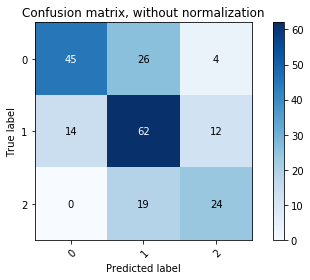

In [2]:
# SVC OVO
clf = svm.SVC(gamma=0.334, C=2.8, decision_function_shape='ovo')
clf.fit(X_combined_train, labels_train)
y_predicted = clf.predict(X_combined_test)
print(accuracy_score(labels_test, y_predicted))
plot_confusion_matrix(labels_test, y_predicted, np.array(('0', '1', '2')))
plt.show()


0.49514563106796117
Confusion matrix, without normalization
[[37 31  7]
 [21 52 15]
 [ 3 27 13]]


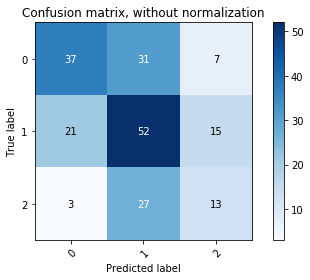

In [3]:
# Metric labeling
PSP_array_train = [[x[0], 1-x[0]] for x in PSP_array_train]
PSP_array_test = [[x[0], 1-x[0]] for x in PSP_array_test]

clf = svm.SVC(gamma=0.334, C=2.8, decision_function_shape='ovo')
clf.fit(X_combined_train, labels_train)
preferences = clf.decision_function(X_combined_train)

k_param = 3
nnc = train_nnc(PSP_array_train, k=k_param)
y_predicted = metric_labeling(PSP_array_train, labels_train, PSP_array_test, preferences, possible_labels, nnc, alpha=0.7, k=k_param)
print(accuracy_score(labels_test, y_predicted))
plot_confusion_matrix(labels_test, y_predicted, np.array(('0', '1', '2')))
plt.show()


In [4]:
X_combined_train.shape

(821, 12002)

In [9]:
from scipy.optimize import minimize
from metric_labeling import metric_labeling_opt
# Metric labeling
PSP_array_train = [[x[0], 1-x[0]] for x in PSP_array_train]
PSP_array_test = [[x[0], 1-x[0]] for x in PSP_array_test]

clf = svm.SVC(gamma=0.334, C=2.8, decision_function_shape='ovo')
clf.fit(X_combined_train, labels_train)
preferences = clf.decision_function(X_combined_train)


In [11]:

res = minimize(metric_labeling_opt, np.array([0.2, 5]), args=(PSP_array_train, labels_train, PSP_array_test, preferences, possible_labels))


[0.2 5. ]
5.0
5.0


TypeError: n_neighbors does not take <class 'numpy.float64'> value, enter integer value